# Práctica 3

**Alumno**: Iván Cañaveral Sánchez

En este notebook se afronta un problema de clasificación binaria de textos, apoyándonos principalmente en laa librería tensorflow.

Durante el desarrollo de la práctica se cubrirán los siguientes aspectos:
 - Carga del dataset y vectorización
 - Pruebas para entender el funcionamiento de las redes recurrentes.
 - Primeros entrenamientos con RNNs simples
 - Entrenamientos con LSTM
 - Entrenamientos con GRU

# Imports y constantes

En esta sección importamos todas las librerías y herramientas que vamos a utilizar, y a continuación se definen algunas constanates y ajustes que se aplicarán a lo largo de toda la práctica.

## Imports

In [ ]:
import os
import re
import json
import time
import shutil
import string
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import utils
from tensorflow.keras.layers import TextVectorization

In [ ]:
from tensorflow.keras.layers import SimpleRNN

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
import nltk
from nltk.stem import *
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords


nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')

## Constantes

In [ ]:
BATCH_SIZE = 32
VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 50 #250
EMBEDDING_DIM = 64

In [ ]:
sns.set_theme()
sns.set(rc={'figure.figsize':(12, 6)})

In [ ]:
# Sets all random seeds for the program (Python, NumPy, and TensorFlow).
tf.random.set_seed(73)

Vamos a crear una función que limpie la sesión de keras y fije una [semilla para procesos aleatorios](https://www.tensorflow.org/api_docs/python/tf/random/set_seed).

In [ ]:
def reset_session():
  tf.keras.backend.clear_session()
  tf.random.set_seed(73)

# Dataset

Vamos a proceder a cargar y procesar el dataset. Este apartado es muy similar al desarrollado en prácticas anteriores, por lo que no entraremos mucho en detalles.

### Carga

In [ ]:
!git clone https://github.com/ivanCanaveral/msc-datasets/

In [ ]:
raw_test_data = pd.read_csv('msc-datasets/movie-reviews/test_reviews.csv')
raw_train_data = pd.read_csv('msc-datasets/movie-reviews/train_reviews.csv')

In [ ]:
raw_test_data['partition'] = 'test'
raw_train_data['partition'] = 'train'
dataset = pd.concat([raw_test_data, raw_train_data])

In [ ]:
dataset = dataset.set_index(dataset.id).drop(columns=["id"])
dataset["length"] = dataset.review.str.split().apply(len)
dataset.head()

### Exploración

In [ ]:
dataset.groupby(by=["partition", "sentiment"]).count()

### Procesado del texto

Como en prácticas anteriores, vamos a creamos una clase que hereda de las clases de estimadores de Sklearn para encapsular el preprocesado del texto.

⚠️ `WordNetLemmatizer()` no es un objeto serializable por joblib (una de las librerías que utiliza sklearn para paralelizar cálculos), por lo que ajustaremos la opción njobs=1, para evitar potenciales problemas.

Para, una vez más, aportar sencillez, vamos a establecer 3 tipos de preprocesado, que serán incrementales:

    * `basic`: únicamente se hace una limpieza básica, pasando a minúsculas, filtrando caracteres indeseados y stopwords.
    * `lemma`: sobre el tratamiento basic se aplica lemmatización.

    * `stem`: adicionalmente al lemmatizado, se aplica stemming.



In [ ]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, level='basic'):
        assert level in ['basic', 'lemma', 'stem'], "Wrong level value"
        self.level = level
        self.apply_lemma = level != 'basic'
        self.apply_stem = level == 'stem'
    
    def clean_text(self, text):
        letters_only = re.sub("[^a-zA-Z]", " ", text)
        words = letters_only.lower().split()
        stops = set(stopwords.words("english") + ['br'])
        words = [w for w in words if not w in stops]
        return words

    def lemmatize_words(self, words):
        wordnet_lemmatizer = WordNetLemmatizer()
        lemmatized = [wordnet_lemmatizer.lemmatize(word) for word in words]
        return lemmatized
    
    def stem_words(self, words):
        stemmer = PorterStemmer()
        stemmed = [stemmer.stem(word) for word in words]
        return stemmed

    def parse_text(self, text):
        words = self.clean_text(text)
        if self.apply_lemma:
            words = self.lemmatize_words(words)
        if self.apply_stem:
            words = self.stem_words(words)
        return " ".join(words)

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return np.vectorize(self.parse_text)(X)

    def get_params(self, deep=True):
        return {
            "level": self.level
        }

In [ ]:
for prep_type in ['basic', 'lemma', 'stem']:
  print("Procesando...", prep_type, end=' ')
  t0 = time.time()
  text_preprocessor = TextPreprocessor(prep_type)
  dataset[f'{prep_type}_review'] = text_preprocessor.transform(dataset.review)
  print(f"{time.time()-t0:02f} s.")

In [ ]:
dataset['label'] = dataset['sentiment'] == 'positive'
dataset['label'] = dataset['label'].astype('int32')
dataset.head(2)

In [ ]:
train_df = dataset[dataset['partition'] == 'train']
test_df = dataset[dataset['partition'] == 'test']

Vamos a partir el conjunto de entrenamiento y validación para monitorizar los entrenamientos con keras. De este modo tendremos 3 conjuntos de tados:
* test
* validation
* train

In [ ]:
train_df, validation_df = train_test_split(train_df, test_size=0.1, random_state=73)

### Vectorización

Vamos a crear objetos Dataset de tensorflow para llevar a cabo entrenamientos de manera más eficiente.

In [ ]:
raw_train_ds = tf.data.Dataset.from_tensor_slices(
    (train_df['lemma_review'], train_df['label'].values)).batch(BATCH_SIZE)
raw_test_ds = tf.data.Dataset.from_tensor_slices(
    (test_df['lemma_review'], test_df['label'].values)).batch(BATCH_SIZE)
raw_validation_ds = tf.data.Dataset.from_tensor_slices(
    (validation_df['lemma_review'], validation_df['label'].values)).batch(BATCH_SIZE)

Exploremos como se almacenan los textos y sus etiquetas en estos datasets. Utilizaremos como ejemplo en dataset de entrenamiento:

In [ ]:
for text_batch, label_batch in raw_train_ds.take(1): #first batch
  for i in range(2): # first 2 elements form raw_train_ds
    print("Review: ", text_batch.numpy()[i][:80])
    print("Label:", label_batch.numpy()[i], '\n')

**Capa de vectorizacion:** Para las pruebas vamos a crear una vectorización de tipo 'int', que genera un vocabulario y asigna a cada palabra el índice que tiene asociado en el vocabulario.

In [ ]:
seq_vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH)

**Ajuste del vectorizador:** Para ajustar el vectorizador, vamos a hacerlo únicamente sobre la partición de de train. Para ello vamos a crear una función que filtre las etiquetas, ajuste el vectorizador, y aplicamos la capa de vectorización sobre los datasets.

In [ ]:
def filter_labels(text, labels):
  return text

train_text = raw_train_ds.map(filter_labels)
seq_vectorize_layer.adapt(train_text)

In [ ]:
def seq_vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return seq_vectorize_layer(text), label

### Pruebas de vectorización

Vamos a revisar paso a paso cómo funcionan los pasos de la vectorización y qué impacto tiene.

En primer lugar tomamos una muestra, tanto el texto como su etiqueta:

In [ ]:
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review: ", first_review.numpy()[:100])
print("Label: ", first_label.numpy())

A continuación vemos el impacto que tiene aplicar la capa de vectorización definida previamente:

In [ ]:
print("Vectorización secuencial:")
print(seq_vectorize_text(first_review, first_label)[0])

Cada uno de estos índices se corresponden con una palabra del vocabulario. Por ejemplo, vamos a ver a qué palabras están asociados los índices 2 y 3 del vocabulario:

In [ ]:
print("2 ---> ", seq_vectorize_layer.get_vocabulary()[2])
print("3 ---> ", seq_vectorize_layer.get_vocabulary()[3])
print("Vocabulary size: {}".format(len(seq_vectorize_layer.get_vocabulary())))

Vamos a hacer entonces una pequeña prueba, aplicando la capa de vectorización, y después recuperando las palabras del vocabulario. Es decir, vamos a vectorizar texto, y después a hacer la operación inversa.

In [ ]:
print("Reverse vectorization:")
for word_index in seq_vectorize_text(first_review, first_label)[0].numpy()[0]:
  print(seq_vectorize_layer.get_vocabulary()[word_index], end=' ')

### Configuración de los datasets

Finalmente creamos los datasets que consumirán los enterenamientos. Aplicamos la función de vectorización definida anteriormente.

(!) Aplicamos la vectorización dentro del dataset para mejorar la eficiencia de los entrenamientos en caso de utilizar soportes de cómputo tales como GPUs. En caso de desplegar este modelo en inferencia, lo más práctico sería incluir la vectorización dentro del modelo.

In [ ]:
seq_train_ds = raw_train_ds.map(seq_vectorize_text)
seq_test_ds = raw_test_ds.map(seq_vectorize_text)
seq_validation_ds = raw_validation_ds.map(seq_vectorize_text)

Aplicamos algunas optimizacaiones de rendimiento. En este caso, paralelizar los cálculos de la vectorización.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

def configure_dataset(dataset):
  return dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
seq_train_ds = configure_dataset(seq_train_ds)
seq_test_ds = configure_dataset(seq_test_ds)
seq_validation_ds = configure_dataset(seq_validation_ds)

# Redes recurrentes.

A lo largo del siguiete apartado iremos explorando y aplicando diferentes arquitecturas de redes recurrentes, y midiendo su rendimiento.

Se estudian arquitecturas simples, apiladas y bidireccionales, sobre los siguientes típos básicos de redes recurrentes:
- SimpleRNN
- LSTM
- GRU

En el primer apartado nos detendremos un poco más para entender las funcionalidades de la librería, así como los aspecto internos de este tipo de redes.

## Unidades `SimpleRNN`

En keras, `RNN` es una cláse básica de la que heredan los distintos tipos de redes recurrentes. El módulo más básico de red recurrente, el de red recurrente básico es [SimpleRNN](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN).


Cada paso temporal de esta red recurrente responde al siguiente cálculo:

```
h_(t+1) = x_t * W_x + h_t * W_h
```

Donde `x_t` y `x_(t+1)` son los inputs de la red en un punto concreto de la secuencia, y el siguiente punto, `h_t` y `h_(t+1)` con los estados de la misma, y `W_x` y `W_h` son las matrices de pesos asociados al input, y al estado respectivamente.

### Pesos

En el siguiente apartado vamos a explorar en detalle cómo se gestionan y se accede a los pesos y estados internos de las redes. 

Para ello partiremos de una capa de vectorización tipo Embedding (este punto es poco relevante, dado que en este apartado queremos centrarnos en la red), e iremos revisando algunos detalles.

En primer lugar, supongamos un embedding sencillo con dos dimensiones, que mapea las palabras a un espacio con las dimensiones (E1, E2).

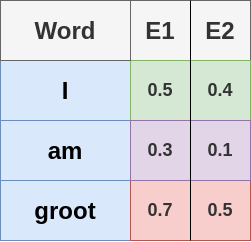

Para simular este embedding, vamos a generar un vector aleatorio que representa, como en la imágen, una frase de tres palabras, en un espacio bidimensional.

Por tanto, tendremos una matriz de 1x3x2:

In [ ]:
# n_sentences, n_sentence_lenght, dim
x = tf.random.normal((1, 3, 2))
x.numpy()[0]

Ahora vamos a crear una capa recurrente con 4 unidades.

In [ ]:
layer = SimpleRNN(4, input_shape=(3, 2))
output = layer(x)
output.shape

Esta red, internamente genera las matrices de pesos correspondientes a:

- la entrada `x`
- el estado anterior `h`
- y el bias.

A continuación podemos ver las dimensiones de cada una de ellas para la red planteada:

In [ ]:
for w, name in zip(layer.weights, ["W_x", "W_h", "b"]):
  print(name, w.shape)

Si queremos explorar un poco más, podemo ver en detalle las distintas matrices:

In [ ]:
for w, name in zip(layer.weights, ["W_x", "W_h", "b"]):
  print(name, '\n---')
  print(w.numpy())
  print()

### Estados

En redes recurrentes, se denominan estados a la información que la propia red envía de un paso temporal a otro. En el caso de las redes recurrentes simples, este estado además es el output de cada aplicación de la red, y es un vector que tiene tantas variables como unidades de la red.

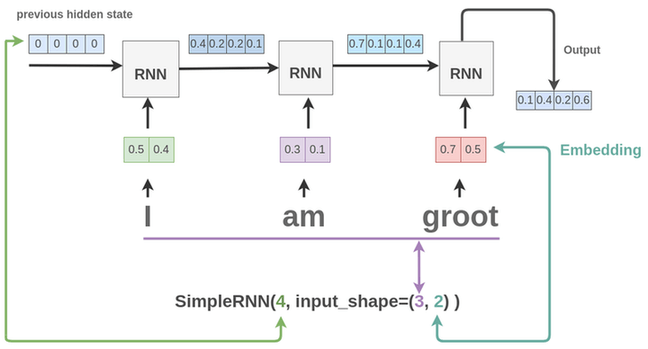

Vamos a crear una `SimpleRNN` de pruebas, y vamos a comprobar que su output se comporta como se espera.

En este caso, la red iterará por las 3 palabras, y dará como resultado un output que tiene tantas dimensiones como unidades. Este output corresponde con el estado final de la red.

In [ ]:
layer = SimpleRNN(4, input_shape=(3, 2))
output = layer(x)
output.shape

In [ ]:
output.numpy()

**Secuencias interntas**

Sin embargo, la red emite outputs intermedios, que a priori no están reflejados en el output. Si nos interesa obtenerlos (para poder explorarlos, o para reutilizarlos en arquitecturas más complejas), keras nos da la opción de obtenerlos si marcamos el parámetro:

```python
return_sequences=True
```

En este caso, el output contendrá todos los outputs intermedios.

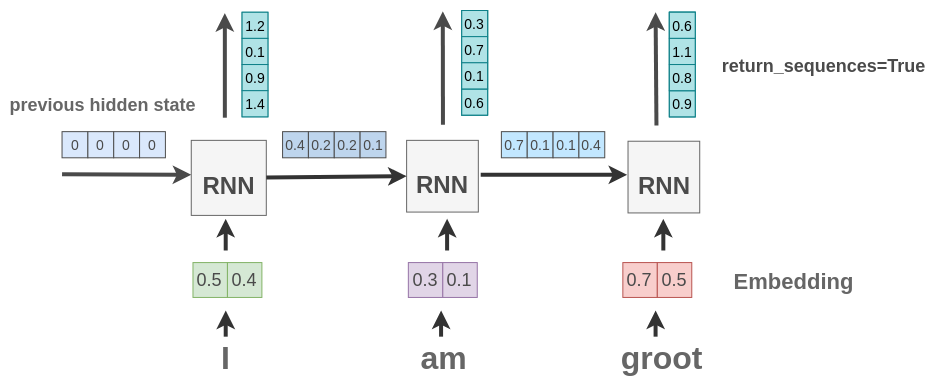

In [ ]:
layer = SimpleRNN(
    4, input_shape=(3, 2), return_sequences=True)
output = layer(x)
print(output.shape)

Como podemos observar, hemos obtenido un output con la forma: `(n_timesteps, n_units)`.

In [ ]:
output.numpy()

**Estados interntas**

Del mismo modo, podemos obtener los estados internos finales de la red, con el parámetro 

```python
return_state=True
```

En este caso, el output contendrá todos los outputs intermedios, y adicionalmente los estados internos de la red. Los estados internos cambiarán en función del tipo de unidades recurrentes quue estemos utilizando.

In [ ]:
layer = SimpleRNN(
    4, input_shape=(3, 2), return_sequences=True, return_state=True)
sequence_output, final_state = layer(x)

print(sequence_output.shape, final_state.shape)

In [ ]:
sequence_output.numpy()

En este caso (`SimpleRNN`) coincide con el último estado de la secuencia.

In [ ]:
final_state.numpy()

### Pruebas

Vamos a llevar a cabo algunas pruebas de entrenamiento para entender las dinámicas de este tipo de redes. En este punto no nos centraremos tanto en explorar el resultado de los entrenamientos, si no a las dinámicas internas de los modelos.

Antes de comenzar con las pruebas, vamos a definir algunas funciones que nos serán de utilidad.

In [ ]:
def format_history(history):
  """
  Cast keras history into a pandas DataFrame
  """
  hist = pd.DataFrame(history.history)
  rows = []
  for epoch, record in enumerate(hist.to_dict(orient='records')):
    for metric, value in record.items():
      kind = 'train'
      if 'val' in metric:
        kind = 'validation'
      metric = metric.replace('val_', '')
      rows.append(
          {
            'epoch': epoch,
            'kind': kind,
            'metric': metric,
            'value': value
          }
      )
  return pd.DataFrame(rows)

In [ ]:
def plot_metrics(hist_df):
  """
  This funcion plots a history DataFrame.
  """
  pal = dict(validation="#6495ED", train="#F08080")
  sns.relplot(
      data=hist_df, x="epoch", y="value", col="metric",
      hue="kind", style="kind", kind="line", palette=pal
  )

In [ ]:
def plot_history(history):
  """
  Plots keras history
  """
  hist_df = format_history(history)
  plot_metrics(hist_df)

In [ ]:
def plot_confusion_matrix(model, test_dataset):
  """
  plots confusion matrix
  """
  preds = model.predict(test_dataset)
  true_labels = np.hstack([labels.numpy() for _, labels in test_dataset])
  pred_labels = preds > 0
  cm = confusion_matrix(true_labels, pred_labels)
  ConfusionMatrixDisplay(
      confusion_matrix=cm,
      display_labels=['negative', 'positive']
  ).plot(cmap='Purples')

In [ ]:
def get_metrics(model, test_dataset):
  """
  Shows classification report
  """
  preds = model.predict(test_dataset)
  true_labels = np.hstack([labels.numpy() for _, labels in test_dataset])
  pred_labels = preds > 0
  print(classification_report(
      true_labels, pred_labels, target_names=['negative', 'positive']))

In [ ]:
def get_gradient_overview(model, sample, n=5):
  """
  computes gradients and show them
  """
  x, y = list(sample)[0]
  with tf.GradientTape(persistent=True) as tape:
    y_pred = model(batch, training=True)
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(y, y_pred)
  grads = tape.gradient(loss, model.trainable_weights)
  for grad in grads[:n]:
    print(grad.shape)
    print(tf.reduce_mean(grad))
    try:
      grads = grad.values.numpy().flatten()
    except AttributeError:
      grads = grad.numpy().flatten()
    pd.DataFrame(grads).plot.hist(bins=20)
    print()

También vamos a definir un par de callbacks de keras que serán de utilidad durante los entrenamientos.

In [ ]:
early_stopping_cb = EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=3,
    min_delta=0.001
)

In [ ]:
learning_rate_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    min_lr=0.0001
)

#### Prueba 1: primer entrenamiento

En esta prueba simplemente vamos a llevar a cabo un primer entrenamiento. Para ello definimos un Embedding y una única unidad de tipo `SimpleRNN`.

In [ ]:
reset_session()

In [ ]:
inputs1 = layers.Input(
    shape=(MAX_SEQUENCE_LENGTH)) # No ponemos el batch_size. (32, 250) fallaría
emb = tf.keras.layers.Embedding(
    input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM)(inputs1)
rnn = SimpleRNN(
    1)(emb)
model = tf.keras.Model(inputs=inputs1, outputs=rnn)

In [ ]:
model.summary()

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

Dado que estamos haciendo pruebas para entender el funcionamiento interno de la red, vamos  autilizar el dataset de test como validación, por contar con más muestras.

In [ ]:
%%time
history = model.fit(seq_train_ds, epochs=10,
                    validation_data=seq_test_ds,
                    batch_size=BATCH_SIZE,
                    verbose=1)

In [ ]:
plot_history(history)

Como podemos observar, aunque en el dataset de train el entrenamiento avanza, en el conjunto de test apenas ha habido ningún cambio. Esto suele indicar un problema claro de overfitting, sin embargo, dado que el modelo es sencillo, y que ejecutando este experimento la variabilidad de los resultados ha sido alta, esto nos hace sospechar también de problemas con la inicialización.

Para paliar esto, además de incluir funciones de regularización, vamos a explorar la manera en la que se inicializan los pesos.

#### Prueba 2: Inicialización

Com se indicaba en la conclusión de la prueba anterior, vamos a explorar los inicializadores de pesos, además de incluir cierta regularización para intentar desbloquear los entrenamientos.

In [ ]:
reset_session()

Vamos a hacer una red de 1 unidad, por lo que no hace falta capa densa.

##### Initializers

A continuación exploramos algunos inicializadores de pesos de los que disponemos en keras. Por defecto, en estas librerías se suelen utilizar algunos inicializadores complejos, y es importante entenderlos.

###### HE

Este tipo de funciones de suelen tener en cuenta el tamaño de la muestra a generar. Como podemos observar a continuación, cuanto menor es el tamaño de la muestra de pesos, mayor es la variabilidad.

Por tanto, para redes con pocos pesos es fácil obtener comportamientos muy variables y dar lugar a entrenamientos que se quedan atascados, dado que las funciones de activación suelen estar centradas en el cero.

In [ ]:
initializer = tf.keras.initializers.HeUniform()
pd.DataFrame(initializer(shape=(10,))).plot.hist(bins=10)

In [ ]:
# cuando más, menor rango
initializer = tf.keras.initializers.HeUniform()
pd.DataFrame(initializer(shape=(10000,))).plot.hist(bins=100)

In [ ]:
initializer = tf.keras.initializers.HeNormal()
pd.DataFrame(initializer(shape=(10,))).plot.hist(bins=10)

In [ ]:
initializer = tf.keras.initializers.HeNormal()
pd.DataFrame(initializer(shape=(10000,))).plot.hist(bins=100)

###### Glorot

En este tipo de funciones se repite el mismo comportamiento.

In [ ]:
initializer = tf.keras.initializers.GlorotNormal()
pd.DataFrame(initializer(shape=(10,))).plot.hist(bins=10)

In [ ]:
initializer = tf.keras.initializers.GlorotNormal()
pd.DataFrame(initializer(shape=(10000,))).plot.hist(bins=100)

###### Orthogonal

En este tipo de funciones se persigue que la muestra generada represente una base ortogonal en un espacio vectorial asociado, y como podemos ver, también tiene un comportamiento similar a los casos anteriores.

In [ ]:
# Standalone usage:
initializer = tf.keras.initializers.Orthogonal()
pd.DataFrame(initializer(shape=(1, 10)).numpy().flatten()).plot.hist(bins=10)

In [ ]:
initializer = tf.keras.initializers.Orthogonal()
pd.DataFrame(initializer(shape=(1, 1000)).numpy().flatten()).plot.hist(bins=100)

###### LeCun

En este caso volvemos a tener un comportamiento similar. No vamos a reproducir varios experimentos. Simplemente vamos a generar una distribución "normal" para ver cómo queda su forma.

In [ ]:
initializer = tf.keras.initializers.LecunNormal()
pd.DataFrame(initializer(shape=(10000,))).plot.hist(bins=100)

###### Básicos

Llegado a este punto, para redes muy pequeñas, una opción sensata parece ser utilizar los generadores básicas (truncados o no), en los que podemos controlar la variabilidad de la muestra de manera sencilla.

In [ ]:
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05)
pd.DataFrame(initializer(shape=(10000,))).plot.hist(bins=100)

In [ ]:
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05)
pd.DataFrame(initializer(shape=(10,))).plot.hist(bins=10)

In [ ]:
initializer = tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.05)
pd.DataFrame(initializer(shape=(10000,))).plot.hist(bins=100)

Con valores tan pequeños, normal y uniforme dan un poco igual

##### Segundo entrenamiento

Vamos a ver qué ocurre si controlamos la generación de pesos inicial y aplicamos regularización.

In [ ]:
reset_session()

In [ ]:
inputs1 = layers.Input(
    shape=(MAX_SEQUENCE_LENGTH)) 
emb = tf.keras.layers.Embedding(
    input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM)(inputs1)
rnn = SimpleRNN(
    1,
    kernel_initializer=tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=73),#HeNormal(seed=73),
    recurrent_initializer=tf.keras.initializers.HeUniform(seed=73),
    bias_initializer=tf.keras.initializers.GlorotNormal(seed=73),
    kernel_regularizer=tf.keras.regularizers.L2()
    )(emb)
model = tf.keras.Model(inputs=inputs1, outputs=rnn)

In [ ]:
model.summary()

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

In [ ]:
%%time
history = model.fit(seq_train_ds, epochs=5,
                    validation_data=seq_test_ds,
                    batch_size=BATCH_SIZE,
                    verbose=1)

In [ ]:
plot_history(history)

Como podemos observar, únicamente conteniendo la variabilidad de la matriz de pesos del kernel y forzando la regularización, el entrenamiento comienza a avanzar en el conjunto de test.

##### Exploración de la red

Vamos a revisar los aspectos internos de la red para entender mejor lo que ocurre.

En primer lugar, vamos a revisar cómo han quedado las matrices de pesos, y la magnitud de sus valores.

In [ ]:
for w, name in zip(model.layers[2].weights, ["W_x", "W_h", "b"]):
  print(name, '\n---')
  print(w.numpy().flatten()[:10])
  print()

Para poder entender bien cómo funcionan estos pesos, vamos a generar una red que genere outputs intermedios, y vamos a cargar los pesos del entrenamiento que acabamos de realizar, para ver cómo varían los outputs intermedios a lo largo de las frases analizadas por la red.

In [ ]:
emb_weights = model.layers[1].get_weights()

In [ ]:
rnn_weights = model.layers[2].get_weights()

In [ ]:
inputs1 = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH)) # No ponemos el batch_size. 32, 250 fallaría
emb = tf.keras.layers.Embedding(
    input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM)(inputs1)
rnn = SimpleRNN(1, return_sequences=True)(emb)
model = tf.keras.Model(inputs=inputs1, outputs=rnn)

In [ ]:
model.layers[1].set_weights(emb_weights)

In [ ]:
model.layers[2].set_weights(rnn_weights)

In [ ]:
batch = list(seq_train_ds)[0][0]

In [ ]:
preds = model.predict(batch)

Una vez montada la nueva red, vamos a explorar cómo responde antes distintas frases del conjunto de entrenamiento:

In [ ]:
n = 5
x = preds[n].flatten()
words = [seq_vectorize_layer.get_vocabulary()[word_index] for word_index in batch[n].numpy()]
plt.figure(figsize=(12,6))
plt.xticks(range(MAX_SEQUENCE_LENGTH), words, rotation=75)
plt.plot(x)

Como podemos observar, la red comienza a mostrar comporamientos con cierto sentido. En este caso, palabras como `lazy` o `crummy` hacen que la red mueva la clasificación claramente hacia polaridades negativas, mientras que ante secuencias como `best scene` tiene el comportamiento opuesto. 

In [ ]:
n = 6
x = preds[n].flatten()
words = [seq_vectorize_layer.get_vocabulary()[word_index] for word_index in batch[n].numpy()]
plt.figure(figsize=(12,6))
plt.xticks(range(MAX_SEQUENCE_LENGTH), words, rotation=75)
plt.plot(x)

En este caso vemos como la secuencia es en general positiva, hasta que aparece `viewed glass claim bad` hace que la red cambie completamente la polaridad de la frase.

In [ ]:
n = 9
x = preds[n].flatten()
words = [seq_vectorize_layer.get_vocabulary()[word_index] for word_index in batch[n].numpy()]
plt.figure(figsize=(12,6))
plt.xticks(range(MAX_SEQUENCE_LENGTH), words, rotation=75)
plt.plot(x)

En este caso podemos observar algo similar, al encontrar la secuencia `making got painful drawn prettig boring attempt`.

#### Prueba 3: Incremento en el número de unidades.

A continuación vamos a ver qué ocurre cuando incrementamos el número de unidades recurrentes de la red.

In [ ]:
reset_session()

In [ ]:
inputs1 = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH))
emb = tf.keras.layers.Embedding(
    input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM)(inputs1)
rnn = SimpleRNN(
    4,
    kernel_initializer=tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=73),
    recurrent_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.05, maxval=0.05, seed=73
    ),#tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=73),#HeUniform(seed=73),
    bias_initializer=tf.keras.initializers.GlorotNormal(seed=73),
    kernel_regularizer=tf.keras.regularizers.L2()
    )(emb)
dense = tf.keras.layers.Dense(1)(rnn)
model = tf.keras.Model(inputs=inputs1, outputs=dense)

In [ ]:
model.summary()

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

In [ ]:
history = model.fit(seq_train_ds, epochs=5,
                    validation_data=seq_validation_ds,
                    batch_size=BATCH_SIZE)

In [ ]:
plot_history(history)

##### Exploración de la red

Vamos a realizar el mismo ejercicio del apartado anterior, y ver cómo colaboran las diferentes unidades.

In [ ]:
emb_weights = model.layers[1].get_weights()
rnn_weights = model.layers[2].get_weights()
dense_weights = model.layers[3].get_weights()

In [ ]:
inputs1 = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH)) # No ponemos el batch_size. 32, 250 fallaría
emb = tf.keras.layers.Embedding(
    input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM)(inputs1)
rnn = SimpleRNN(4, return_sequences=True)(emb)
dense = tf.keras.layers.Dense(1)(rnn)
model = tf.keras.Model(inputs=inputs1, outputs=rnn) #rnn para tener sus outputs

In [ ]:
model.layers[1].set_weights(emb_weights)
model.layers[2].set_weights(rnn_weights)
#model.layers[3].set_weights(dense_weights)

In [ ]:
batch = list(seq_train_ds)[0][0]

In [ ]:
preds = model.predict(batch)

In [ ]:
n = 5
x = preds[n].flatten()
words = [seq_vectorize_layer.get_vocabulary()[word_index] for word_index in batch[n].numpy()]
for i, w in enumerate(dense_weights[0]):
  print(f'unit-{i+1} weight:', w[0])

plt.figure(figsize=(12,6))
plt.xticks(range(MAX_SEQUENCE_LENGTH), words, rotation=75)
plt.plot(preds[n][:,0], label="unit-1")
plt.plot(preds[n][:,1], label="unit-2")
plt.plot(preds[n][:,2], label="unit-3")
plt.plot(preds[n][:,3], label="unit-4")
plt.legend(loc="upper left")

Podemos observar como las 4 unidades tienen comportamientos muy similares. De hecho, la unidad 2, que es la que tiene un comportamiento un poco distinto, en realidad tiene un comportamiento opuesto, pero si observamos el peso que se asicia a esa unidad en la capa densa del final, este es negativo. Por lo tanto, todas las unidades se comportan de manera muy similar.

Esto nos indica, que la ganancia al añadir nuevas unidades no será muy grande. Al menos, la precisión no crecerá de manera lineal con el número de unidades ya desde un bajo número de unidades.

In [ ]:
n = 8
x = preds[n].flatten()
words = [seq_vectorize_layer.get_vocabulary()[word_index] for word_index in batch[n].numpy()]
for i, w in enumerate(dense_weights[0]):
  print(f'unit-{i+1} weight:', w[0])

plt.figure(figsize=(12,6))
plt.xticks(range(MAX_SEQUENCE_LENGTH), words, rotation=75)
plt.plot(preds[n][:,0], label="unit-1")
plt.plot(preds[n][:,1], label="unit-2")
plt.plot(preds[n][:,2], label="unit-3")
plt.plot(preds[n][:,3], label="unit-4")
plt.legend(loc="upper left")

Ocurre lo mismo en este ejemplo. Podemo sobservar como el comportamiento de todas ante la palabra `fascinating` cambia drásticamente.

#### Prueba 4: Arquitectura bidireccional

En esta prueba vamos a ver qué ocurre si, sobre las pruebas anteriores, modificamos la arquitectura para que sea bidireccional.

In [ ]:
reset_session()

In [ ]:
inputs1 = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH)) # No ponemos el batch_size. 32, 250 fallaría
emb = tf.keras.layers.Embedding(
    input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM)(inputs1)
rnn = tf.keras.layers.Bidirectional(SimpleRNN(
    4,
    kernel_initializer=tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=73),#HeNormal(seed=73),
    recurrent_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.05, maxval=0.05, seed=73
    ),#tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=73),#HeUniform(seed=73),
    bias_initializer=tf.keras.initializers.GlorotNormal(seed=73),
    kernel_regularizer=tf.keras.regularizers.L2()
    ))(emb)
dense = tf.keras.layers.Dense(1)(rnn)
model = tf.keras.Model(inputs=inputs1, outputs=dense)

In [ ]:
model.summary()

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

In [ ]:
history = model.fit(seq_train_ds, epochs=5,
                    validation_data=seq_test_ds,
                    batch_size=BATCH_SIZE)

In [ ]:
plot_history(history)

##### Exploración de la red

Repetimos el ejercicio de las pruebas anteriores.

In [ ]:
emb_weights = model.layers[1].get_weights()
rnn_weights = model.layers[2].get_weights()
dense_weights = model.layers[3].get_weights()

In [ ]:
inputs1 = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH)) # No ponemos el batch_size. 32, 250 fallaría
emb = tf.keras.layers.Embedding(
    input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM)(inputs1)
rnn = tf.keras.layers.Bidirectional(SimpleRNN(4, return_sequences=True))(emb)
dense = tf.keras.layers.Dense(1)(rnn)
model = tf.keras.Model(inputs=inputs1, outputs=rnn) #rnn para tener sus outputs

In [ ]:
model.layers[1].set_weights(emb_weights)
model.layers[2].set_weights(rnn_weights)
#model.layers[3].set_weights(dense_weights)

In [ ]:
preds = model.predict(batch)

In [ ]:
n = 5
x = preds[n].flatten()
words = [seq_vectorize_layer.get_vocabulary()[word_index] for word_index in batch[n].numpy()]
for i, w in enumerate(dense_weights[0]):
  print(f'unit-{i+1} weight:', w[0])

plt.figure(figsize=(12,6))
plt.xticks(range(MAX_SEQUENCE_LENGTH), words, rotation=75)
plt.plot(preds[n][:,0], label="unit-1")
plt.plot(preds[n][:,1], label="unit-2")
plt.plot(preds[n][:,2], label="unit-3")
plt.plot(preds[n][:,3], label="unit-4")
plt.plot(preds[n][:,4], label="unit-5")
plt.plot(preds[n][:,5], label="unit-6")
plt.plot(preds[n][:,6], label="unit-7")
plt.plot(preds[n][:,7], label="unit-8")
plt.legend(loc="upper left")

Podemos ver en este caso como, en el caso anterior, hay unidades que tienen un comportamiento muy similar, mientras que otras tienen curvas prácticamente planas y con una variablilidad baja. 

Si nos fijamos en los pesos de la capa densa, vemos como los pesos de una de las direcciones son notablemente más bajos que en la otra. En un caso muchos por enca de 1, y en el otro, cercanos a cero. 

Este comportamiento indica que la arquitectura bidireccional no está aportando un gran salto en la calidad de los resultados. Podemos observar un comportamiento similar en otras secuencias, como se muestra a continuación.

In [ ]:
n = 8
x = preds[n].flatten()
words = [seq_vectorize_layer.get_vocabulary()[word_index] for word_index in batch[n].numpy()]
for i, w in enumerate(dense_weights[0]):
  print(f'unit-{i+1} weight:', w[0])

plt.figure(figsize=(12,6))
plt.xticks(range(MAX_SEQUENCE_LENGTH), words, rotation=75)
plt.plot(preds[n][:,0], label="unit-1")
plt.plot(preds[n][:,1], label="unit-2")
plt.plot(preds[n][:,2], label="unit-3")
plt.plot(preds[n][:,3], label="unit-4")
plt.plot(preds[n][:,4], label="unit-5")
plt.plot(preds[n][:,5], label="unit-6")
plt.plot(preds[n][:,6], label="unit-7")
plt.plot(preds[n][:,7], label="unit-8")
plt.legend(loc="upper left")

#### Prueba 5: Variaciones en la longitud

Hasta ahora hemos estado trabajando con una longitud de secuencia fija. Vamos a ver cómo varían los resultados si esta vambia.

En las siguientes pruebas, iremos aplicando la misma arquitectura, variando la longitud máxmia de secuencia en la vectorización.

In [ ]:
long_vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=500)

In [ ]:
def filter_labels(text, labels):
  return text

train_text = raw_train_ds.map(filter_labels)
long_vectorize_layer.adapt(train_text)

In [ ]:
long_vectorize_layer.adapt(train_text)

In [ ]:
def long_vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return long_vectorize_layer(text), label

In [ ]:
long_train_ds = raw_train_ds.map(long_vectorize_text)
long_test_ds = raw_test_ds.map(long_vectorize_text)

In [ ]:
long_train_ds = configure_dataset(long_train_ds)
long_test_ds = configure_dataset(long_test_ds)

Vamos a iterar entre 0 y 200 tokens de longitud de secuencia.

In [ ]:
lengths = [(i+1)*20 for i in range(10)]

In [ ]:
%%time
accs = []
val_accs = []
for NEW_LENGTH in lengths:

  reset_session()

  @tf.autograph.experimental.do_not_convert
  def shorten(vects, labels):
    return vects[:,:NEW_LENGTH], labels

  new_train_ds = long_train_ds.map(shorten)
  new_test_ds = long_test_ds.map(shorten)

  inputs1 = layers.Input(shape=(NEW_LENGTH))
  emb = tf.keras.layers.Embedding(
      input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM)(inputs1)
  rnn = SimpleRNN(
      1,
      kernel_initializer=tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=73),#HeNormal(seed=73),
      recurrent_initializer=tf.keras.initializers.HeUniform(seed=73),
      bias_initializer=tf.keras.initializers.GlorotNormal(seed=73),
      kernel_regularizer=tf.keras.regularizers.L2()
      )(emb)
  model = tf.keras.Model(inputs=inputs1, outputs=rnn)

  model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam(1e-3),
                metrics=['accuracy'])
  t0 = time.time()
  history = model.fit(new_train_ds, epochs=5,
                      validation_data=new_test_ds,
                      batch_size=BATCH_SIZE,
                      verbose=0)
  t1 = time.time()
  accs.append(history.history['accuracy'][-1])
  val_accs.append(history.history['val_accuracy'][-1])
  print(NEW_LENGTH, accs[-1], val_accs[-1], f'{t1 - t0:4.2f} s')

Visualicemos la precisión de los conjuntos de entrenamiento y test en función de la longitud.

Recordemos que, dado el carácter de estas primeras pruebas, estamos utilizando el conjunto de test como validación para tener un mayor volúmen de muestras.

In [ ]:
results = pd.DataFrame({'lenght': lengths, 'acc':accs, 'val_acc':val_accs})

In [ ]:
sns.lineplot(results, x='lenght', y='acc', label='acc')
sns.lineplot(results, x='lenght', y='val_acc', label='val_acc')

Como podemos observar, a partir de secuencias de más de 60 tokens, la calidad de los resultados cae claramente. Se reproducido numerosas veces este experimento con los mismos resultados.

Como conclusión, estas redes simples no parecen apropiadas para tratar secuencias de textos largos.

### Entrenamiento 01: SimpleRNN

Despues de las pruebas anteriores, hemos profundizado en aspectos que nos ayudarán a plantear los siguientes entrenamientos, no sólo pen el caso de `SimpleRNN`, si no que también son útiles para el resto de tipos de unidades recurrentes.

A continuación, vamos a hacer un entrenamiento con unidades de tipo `SimpleRNN`, que será consecuencia directa de los últimos apartados.

In [ ]:
reset_session()

In [ ]:
inputs1 = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH)) # No ponemos el batch_size. 32, 250 fallaría
emb = tf.keras.layers.Embedding(
    input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM)(inputs1)
rnn = SimpleRNN(
    4,
    kernel_initializer=tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=73),#HeNormal(seed=73),
    recurrent_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.05, maxval=0.05, seed=73
    ),
    bias_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.05, maxval=0.05, seed=73
    ),
    kernel_regularizer=tf.keras.regularizers.L2()
    )(emb)
dense = tf.keras.layers.Dense(1)(rnn)
model = tf.keras.Model(inputs=inputs1, outputs=dense)

In [ ]:
model.summary()

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    seq_train_ds,
    epochs=20,
    validation_data=seq_validation_ds,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping_cb, learning_rate_cb]
)

#### Results

Vamos a explorar más detenidamente los resultados del entrenamiento. A partir de ahora vamos a utilizar el conjunto de validación para monitorizar el entrenamiento, y el conjunto de test para evaluar los resultados.

En primer lugar, revisemos los resultados directos del entrenamiento.

In [ ]:
plot_history(history)

En el conjunto de validación vamos hemos llegado a una precisión de casi el 78%, aunque como podemos observar a partir de la segunda epoch, tanto la función de pérdida como la precisión no han conseguido mejorar. Esto nos hace pensar que todavía sufrimos de cierto sobreajuste. Podría deberse a que, como hemos visto, existen unidades redundantes. Además de esto, dejamos para más adelante la inclusión del dropout.

Veamos a continuación cómo se comporta el modelo contra el conjunto de test.

In [ ]:
model.evaluate(seq_test_ds)

In [ ]:
preds = model.predict(seq_test_ds)

In [ ]:
get_metrics(model, seq_test_ds)

Como vemos, las métricas obtenidas son algo menores en este conjunto.

A continuación tenemos el detalle de la matriz de confusión.

In [ ]:
plot_confusion_matrix(model, seq_test_ds)

#### Explore

Una vez evaluados los resultados, vamos a explorar en detalle el estado de la red, dado que esto otorga una visión más detallada.

In [ ]:
def get_gradient_overview(model, sample, n=5):
  x, y = list(sample)[0]
  with tf.GradientTape(persistent=True) as tape:
    y_pred = model(batch, training=True)
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(y, y_pred)
  grads = tape.gradient(loss, model.trainable_weights)
  for grad in grads[:n]:
    print(grad.shape)
    print(tf.reduce_mean(grad))
    try:
      grads = grad.values.numpy().flatten()
    except AttributeError:
      grads = grad.numpy().flatten()
    pd.DataFrame(grads).plot.hist(bins=20)
    print()

En primer lugar, vamos a revisar rápidamente los gradientes por cada elemento de la red, y sobre todo su magnitud. Dado que es la primera vez que exploramos este aspecto de la red, el objetivo es simplemente que sirva de referencia de cara a las siguientes secciones.

In [ ]:
get_gradient_overview(model, seq_train_ds)

A continuación, como en secciones anteriores, vamos a revisar el comportamiento detallado de la red sobre textos concretos.

In [ ]:
emb_weights = model.layers[1].get_weights()
rnn_weights = model.layers[2].get_weights()
dense_weights = model.layers[3].get_weights()

In [ ]:
inputs1 = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH)) # No ponemos el batch_size. 32, 250 fallaría
emb = tf.keras.layers.Embedding(
    input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM)(inputs1)
rnn = SimpleRNN(4, return_sequences=True)(emb)
dense = tf.keras.layers.Dense(1)(rnn)
model = tf.keras.Model(inputs=inputs1, outputs=rnn) #rnn para tener sus outputs

In [ ]:
model.layers[1].set_weights(emb_weights)
model.layers[2].set_weights(rnn_weights)

In [ ]:
batch = list(seq_train_ds)[0][0]

In [ ]:
preds = model.predict(batch)

In [ ]:
n = 5
x = preds[n].flatten()
words = [seq_vectorize_layer.get_vocabulary()[word_index] for word_index in batch[n].numpy()]
for i, w in enumerate(dense_weights[0]):
  print(f'unit-{i+1} weight:', w[0])

plt.figure(figsize=(12,6))
plt.xticks(range(MAX_SEQUENCE_LENGTH), words, rotation=75)
plt.plot(preds[n][:,0], label="unit-1")
plt.plot(preds[n][:,1], label="unit-2")
plt.plot(preds[n][:,2], label="unit-3")
plt.plot(preds[n][:,3], label="unit-4")
plt.legend(loc="upper left")

Podemos comprobar que, las unidades tienen comportamientos realmente similares. Únicamente una de ellas tiene un comportamiento inverso pero está asociada a un peso negativo en la capa densa.

Esto sopora claramente la hipótesis sobre el sobre ajuste. Tengamos esto en cuenta para nuevos experimentos, y avancemos para explorar otras arquitecturas.

## Arquitectura `Time distributed`

Por lo general, para problemas de clasificación, se aplica una red densa sobre el output final de la red recurrente si es necesario. También se puede aplicar sobre la secuencia completa aplanando esta. 

Sin embargo, existe la posibilidad de aplicar una misma capa densa sobre cada uno de los outputs intermedios de la red, y ejecutar una red sobre todos los outputs.

Si bien no es una técnica óptima para clasificación de textos, si no que tiene más sentido en problemas como detección de entidades o PoS tagging, nos servirá para introducir un problema muy común en redes recurrentes: los problemas con la escala de los gradientes.


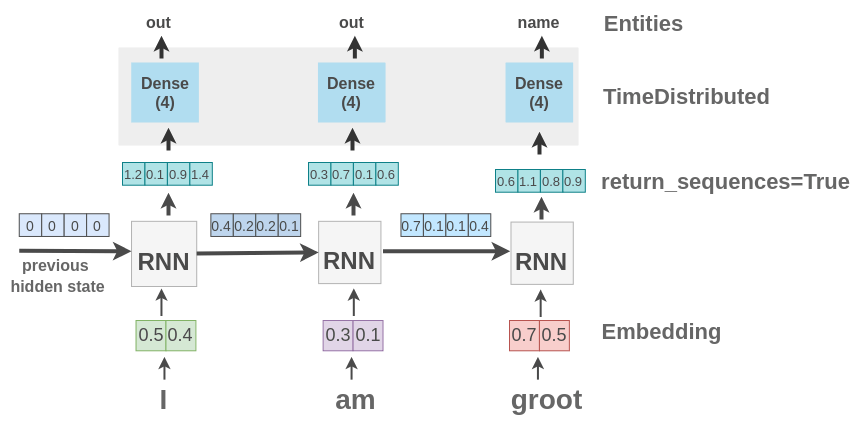

#### Prueba 1: Time distributed + capa densa

En esta primera prueba vamos a llevar a cabo justo el ejemplo mencionado. Una capa densa procesará cada uno de los outputs intermedios, y sobre ella, otra capa intentará llevar a cabo una clasificación final.

En este caso, para poder llevar a cabo el entrenamiento, tendremos que forzar que las unidades recurrentes devuelvan el output durante el entrenamiento.

In [ ]:
reset_session()

In [ ]:
inputs1 = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH))
emb = tf.keras.layers.Embedding(
    input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM)(inputs1)
rnn = SimpleRNN(
    4,
    return_sequences=True, # <-- Input de la red transversal
    return_state=False,
    kernel_initializer=tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=73),#HeNormal(seed=73),
    recurrent_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.05, maxval=0.05, seed=73
    ),
    bias_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.05, maxval=0.05, seed=73
    ),
    kernel_regularizer=tf.keras.regularizers.L2()
    )(emb)
time_dist = tf.keras.layers.TimeDistributed(
    tf.keras.layers.Dense(1, activation='softmax'))(rnn)
flat = tf.keras.layers.Flatten()(time_dist)
dense = tf.keras.layers.Dense(1)(flat)
model = tf.keras.Model(inputs=inputs1, outputs=dense)

In [ ]:
model.summary(
    expand_nested=True,
    show_trainable=True
)

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

Vamos a forzar el entrenamiento hasta las 10 epochs.

In [ ]:
history = model.fit(
    seq_train_ds,
    epochs=10,
    validation_data=seq_test_ds,
    batch_size=BATCH_SIZE,
    callbacks=[learning_rate_cb] #[early_stopping_cb, learning_rate_cb]
)

Como podemos ver, el entrenamiento a penas ha avanzado en sus métricas. Para descartar que sea un problema con la inicialización, repetiremos el ejercicio, pero esta vez sin tocar nada de la inicialización.

In [ ]:
plot_history(history)

#### Prueba 2: Time distributed + capa densa

Repetimos el experimento, dejando la inicialización por defecto.

In [ ]:
reset_session()

In [ ]:
inputs1 = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH)) # No ponemos el batch_size. 32, 250 fallaría
emb = tf.keras.layers.Embedding(
    input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM)(inputs1)
rnn = SimpleRNN(
    4,
    return_sequences=True, # <-- Input de la red transversal
    return_state=False,
    )(emb)
time_dist = tf.keras.layers.TimeDistributed(
    tf.keras.layers.Dense(1, activation='softmax'))(rnn)
flat = tf.keras.layers.Flatten()(time_dist)
dense = tf.keras.layers.Dense(1)(flat)
model = tf.keras.Model(inputs=inputs1, outputs=dense)

In [ ]:
model.summary(
    expand_nested=True,
    show_trainable=True
)

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    seq_train_ds,
    epochs=10,
    validation_data=seq_test_ds,
    batch_size=BATCH_SIZE,
    callbacks=[learning_rate_cb] #[early_stopping_cb, learning_rate_cb]
)

No es necesario explorar más para darse cuenta de que no ha cambiado nada.

Para entender mejor lo que está ocurriendo, debemos atender a los gradientes.

In [ ]:
get_gradient_overview(model, seq_train_ds)

Como podemos observar, los gradientes de todos los componentes son varios órdenes de magnitud inferiores a los del modelo anterior entrenado. De hecho, todos ellos son prácticamente cero.

Dado que esta arquitectura tiene flujos algo más complejos, nos hemos encontrado con un problema muy típico en redes recorrentes. Lo que en inglés se conoce como *vanishing gradients*, que el modelo no es capaz de aprender porque los gradientes se diluyen. También es común el problema contrario, *exploding gradients*, que da lugar a entrenamientos altamente inestables.

En este punto, no vamos a pararnos a resolver este problema para esta red en concreto (ya comentamos que la arquitectura no era la más idónea para este problema), pero no sha servido para intruducir la importancia de vigilar los gradientes al entrenar este tipo de redes.

## Stacked

Vamos a revisar ahora otra arquitectura común a la hora de trabajar con redes recurrentes. Ésta consiste en apilar varias capas de redes recurrentes, cada una de ellas con un número concreto de unidades.

En este caso es importante devolver todos los outputs intermedios, para que la segunda capa pueda leer éstos.

En esta sección llevaremos a cabo varios entrenamientos completos, e iremos comparando los resultados con los obtenidos sin apilamiento.

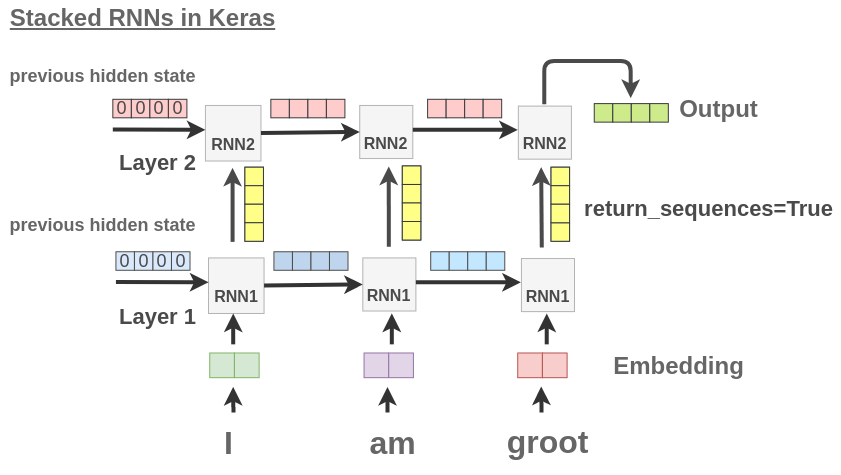

### Prueba 6: 2 stacked layers

Vamos a apilar dos capas de redes recurrentes iguales a las utilizadas anteriormente, y ver el impacto que tiene.

Utilizaremos `SimpleRNN` como las utilizadas previamente, sin aplicar ningún tipo de regularización o inicialización específica.

Al tener más parámetros que el ejemplo anterior, deberíamos tener problemas similares. No vamos a intentar corregirlo en este punto para comprobar que sigue siendo así, pero también para ver, en la exploración, cómo se refleja esta situación en la que el modelo no generaliza bien.

In [ ]:
reset_session()

In [ ]:
inputs1 = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH))
emb = tf.keras.layers.Embedding(
    input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM)(inputs1)
rnn1 = SimpleRNN(
    4,
    return_sequences=True
    )(emb)
rnn2 = SimpleRNN(
    4,
    )(rnn1)
dense = tf.keras.layers.Dense(1)(rnn2)
model = tf.keras.Model(inputs=inputs1, outputs=dense)

In [ ]:
model.summary()

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    seq_train_ds,
    epochs=20,
    validation_data=seq_validation_ds,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping_cb, learning_rate_cb]
)

#### Results

Como esperábamos, aunque el entrenamiento ha progresado (no debería haber problemas con los gradientes), hay problemas graves de generalización.

In [ ]:
plot_history(history)

In [ ]:
model.evaluate(seq_test_ds)

In [ ]:
preds = model.predict(seq_test_ds)

In [ ]:
get_metrics(model, seq_test_ds)

Las métricas sobre el conjunto de test, como era de esperar, no son buenas, pero no es lo importante de este ejemplo. Lo interesante será ver qué ocurre internamente en el modelo.

In [ ]:
plot_confusion_matrix(model, seq_test_ds)

#### Explore

Vamos a hacer una exploración análoga a las anteriores, con este modelo. En primer lugar revisamos los gradientes.

In [ ]:
get_gradient_overview(model, seq_train_ds)

En este punto, aunque se podría profundizar más, a nivel de magnitudes no hay nada llamativo, como era de esperar.

Vamos a revisar que ocurre al procesar secuencias.

In [ ]:
emb_weights = model.layers[1].get_weights()
rnn1_weights = model.layers[2].get_weights()
rnn2_weights = model.layers[3].get_weights()
#dense_weights = model.layers[4].get_weights()

In [ ]:
inputs1 = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH)) # No ponemos el batch_size. 32, 250 fallaría
emb = tf.keras.layers.Embedding(
    input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM)(inputs1)
rnn1 = SimpleRNN(4, return_sequences=True)(emb)
rnn2 = SimpleRNN(4, return_sequences=True)(rnn1)
dense = tf.keras.layers.Dense(1)(rnn2)
model = tf.keras.Model(inputs=inputs1, outputs=rnn2) #rnn para tener sus outputs

In [ ]:
model.layers[1].set_weights(emb_weights)
model.layers[2].set_weights(rnn1_weights)
model.layers[3].set_weights(rnn2_weights)

In [ ]:
preds = model.predict(batch)

In [ ]:
n = 5
x = preds[n].flatten()
words = [seq_vectorize_layer.get_vocabulary()[word_index] for word_index in batch[n].numpy()]
for i, w in enumerate(dense_weights[0]):
  print(f'unit-{i+1} weight:', w[0])

plt.figure(figsize=(12,6))
plt.xticks(range(MAX_SEQUENCE_LENGTH), words, rotation=75)
plt.plot(preds[n][:,0], label="unit-1")
plt.plot(preds[n][:,1], label="unit-2")
plt.plot(preds[n][:,2], label="unit-3")
plt.plot(preds[n][:,3], label="unit-4")
plt.legend(loc="upper left")

Podemos ver que tras la segunda capa recurrente el comportamiento de cada una de las unidades es bastante errático, y no se observan patrones definidos claros.

Vamos a explorar lo que ocurre en la primera capa recurrente, para saber si provoca estas alteraciones.

In [ ]:
model.layers[1].set_weights(emb_weights)
model.layers[2].set_weights(rnn1_weights)
# Lo mejor sería modelo nuevo 
# con pesos de capas 1 y 2
ws = [tf.ones(weights.shape) for weights in rnn2_weights]
ws[-1] = tf.zeros(rnn2_weights[-1].shape)
model.layers[3].set_weights(ws)

In [ ]:
preds = model.predict(batch)

In [ ]:
n = 5
x = preds[n].flatten()
words = [seq_vectorize_layer.get_vocabulary()[word_index] for word_index in batch[n].numpy()]
for i, w in enumerate(dense_weights[0]):
  print(f'unit-{i+1} weight:', w[0])

plt.figure(figsize=(12,6))
plt.xticks(range(MAX_SEQUENCE_LENGTH), words, rotation=75)
plt.plot(preds[n][:,0], label="unit-1")
plt.plot(preds[n][:,1], label="unit-2")
plt.plot(preds[n][:,2], label="unit-3")
plt.plot(preds[n][:,3], label="unit-4")
plt.legend(loc="upper left")

In [ ]:
n = 8
x = preds[n].flatten()
words = [seq_vectorize_layer.get_vocabulary()[word_index] for word_index in batch[n].numpy()]
for i, w in enumerate(dense_weights[0]):
  print(f'unit-{i+1} weight:', w[0])

plt.figure(figsize=(12,6))
plt.xticks(range(MAX_SEQUENCE_LENGTH), words, rotation=75)
plt.plot(preds[n][:,0], label="unit-1")
plt.plot(preds[n][:,1], label="unit-2")
plt.plot(preds[n][:,2], label="unit-3")
plt.plot(preds[n][:,3], label="unit-4")
plt.legend(loc="upper left")

Como podemos ver en los dos ejemplos anteriores, en ambos casos la red toma una decisión prematura, y se estanca a lo largo de la evolución de la secuencia, lo que contrasta con la inestabilidad de la segunda capa.

Si observamos la distribución de pesos de ambas, vemos que la distribución de los pesos de la primera capa se distribuye principalmente en torno al cero, y en la segunda es más uniforme, lo que se corresponde con lo que acabamos de ver.

Cabe destacar, que la inicialización de ambas capas ha sido igual (por defecto).



In [ ]:
pd.DataFrame(np.hstack([w.flatten() for w in rnn1_weights])).plot.hist(bins=20)

In [ ]:
pd.DataFrame(np.hstack([w.flatten() for w in rnn2_weights])).plot.hist(bins=20)

### Entrenamiento 02: 2 stacked layers

En este entrenamiento vamos a corregir los problemas de la prueba anterior, y ver si mejora la precisión respecto al entrenamiento sin apilar capas.

Cambiamos la inicialización e incluimos regularización, como en ejemplos anteriores.

In [ ]:
reset_session()

In [ ]:
inputs1 = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH))
emb = tf.keras.layers.Embedding(
    input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM)(inputs1)
rnn1 = SimpleRNN(
    4,
    return_sequences=True,
    kernel_regularizer=tf.keras.regularizers.L2()
    )(emb)
rnn2 = SimpleRNN(
    4,
    kernel_initializer=tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=73),#HeNormal(seed=73),
    recurrent_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.05, maxval=0.05, seed=73
    ),
    bias_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.05, maxval=0.05, seed=73
    ),
    kernel_regularizer=tf.keras.regularizers.L2()
    )(rnn1)
dense = tf.keras.layers.Dense(1)(rnn2)
model = tf.keras.Model(inputs=inputs1, outputs=dense)

In [ ]:
model.summary()

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    seq_train_ds,
    epochs=20,
    validation_data=seq_validation_ds,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping_cb, learning_rate_cb]
)

#### Results

In [ ]:
plot_history(history)

In [ ]:
model.evaluate(seq_test_ds)

In [ ]:
model.evaluate(seq_test_ds)

In [ ]:
preds = model.predict(seq_test_ds)

In [ ]:
get_metrics(model, seq_test_ds)

A pasar de adolecer de cierto overfitting, añadiendo una nueva capa las métricas han mejorado en el conjunto de test, llegando a un 78% de precisión, cunaod sin apilar capas nos habíamos quedado en el 72%.

In [ ]:
plot_confusion_matrix(model, seq_test_ds)

#### Explore

Vamos a ver cómo se reflejan estos cambios dentro de las mecánicas internas de la red. Exploraremos por separado los resultados tras la primera y segunda capa de redes recurrentes.



##### 2nd stack

Vamos a explorar cómo reacciona la red tras su segunda capa.

In [ ]:
emb_weights = model.layers[1].get_weights()
rnn1_weights = model.layers[2].get_weights()
rnn2_weights = model.layers[3].get_weights()
dense_weights = model.layers[4].get_weights()

In [ ]:
inputs1 = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH))
emb = tf.keras.layers.Embedding(
    input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM)(inputs1)
rnn1 = SimpleRNN(
    4,
    return_sequences=True,
    kernel_regularizer=tf.keras.regularizers.L2()
    )(emb)
rnn2 = SimpleRNN(
    4,
    return_sequences=True,
    kernel_initializer=tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=73),#HeNormal(seed=73),
    recurrent_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.05, maxval=0.05, seed=73
    ),
    bias_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.05, maxval=0.05, seed=73
    ),
    kernel_regularizer=tf.keras.regularizers.L2()
    )(rnn1)
#dense = tf.keras.layers.Dense(1)(rnn2)
model = tf.keras.Model(inputs=inputs1, outputs=rnn2)

In [ ]:
model.layers[1].set_weights(emb_weights)
model.layers[2].set_weights(rnn1_weights)
model.layers[3].set_weights(rnn2_weights)

In [ ]:
batch = list(seq_train_ds)[0][0]

In [ ]:
preds = model.predict(batch)

In [ ]:
n = 5
x = preds[n].flatten()
words = [seq_vectorize_layer.get_vocabulary()[word_index] for word_index in batch[n].numpy()]
for i, w in enumerate(dense_weights[0]):
  print(f'unit-{i+1} weight:', w[0])

plt.figure(figsize=(12,6))
plt.xticks(range(MAX_SEQUENCE_LENGTH), words, rotation=75)
plt.plot(preds[n][:,0], label="unit-1")
plt.plot(preds[n][:,1], label="unit-2")
plt.plot(preds[n][:,2], label="unit-3")
plt.plot(preds[n][:,3], label="unit-4")
plt.legend(loc="upper left")

De la imágen anterior se extraen rápidamente dos cosas:

- Existe una replicación clara entre las distintas unidades. La correlación entre los outputs es incluso mayor que en los casos anteriores.
- La variación según se procesa la secuencia es más suave que en casos anteriores también.

##### 1st stack

Vamo sa explorar la primera capa de pesos.

In [ ]:
inputs1 = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH))
emb = tf.keras.layers.Embedding(
    input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM)(inputs1)
rnn1 = SimpleRNN(4, return_sequences=True)(emb)
dense = tf.keras.layers.Dense(1)(rnn1)
model = tf.keras.Model(inputs=inputs1, outputs=rnn1) #rnn para tener sus outputs

In [ ]:
model.layers[1].set_weights(emb_weights)
model.layers[2].set_weights(rnn1_weights)

In [ ]:
preds = model.predict(batch)

In [ ]:
n = 5
x = preds[n].flatten()
words = [seq_vectorize_layer.get_vocabulary()[word_index] for word_index in batch[n].numpy()]
for i, w in enumerate(dense_weights[0]):
  print(f'unit-{i+1} weight:', w[0])

plt.figure(figsize=(12,6))
plt.xticks(range(MAX_SEQUENCE_LENGTH), words, rotation=75)
plt.plot(preds[n][:,0], label="unit-1")
plt.plot(preds[n][:,1], label="unit-2")
plt.plot(preds[n][:,2], label="unit-3")
plt.plot(preds[n][:,3], label="unit-4")
plt.legend(loc="upper left")

En este caso, los comportamientos de las distintas unidades no son tan similares, y los cambios dentro de los outputs de cada nidad para la misma secuencia son más bruscos que en la capa anterior.

La hipoótesis en este punto es que a mayor número de capas apiladas, más estable es el comportamiento del output. Veamos qué ocurre si añadimos una tercera capa.

### Entrenamiento 03: 3 stacked layers

En este punto, vamos a probar incluyendo una capa adicional, para comprobar cómo impacta en la red y los resultados.

In [ ]:
reset_session()

In [ ]:
inputs1 = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH))
emb = tf.keras.layers.Embedding(
    input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM)(inputs1)
rnn1 = SimpleRNN(
    4,
    return_sequences=True,
    kernel_regularizer=tf.keras.regularizers.L2()
    )(emb)
rnn2 = SimpleRNN(
    4,
    return_sequences=True,
    kernel_initializer=tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=73),
    recurrent_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.05, maxval=0.05, seed=73
    ),
    bias_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.05, maxval=0.05, seed=73
    ),
    kernel_regularizer=tf.keras.regularizers.L2()
    )(rnn1)
rnn3 = SimpleRNN(
    4,
    kernel_initializer=tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=73),
    recurrent_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.05, maxval=0.05, seed=73
    ),
    bias_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.05, maxval=0.05, seed=73
    ),
    kernel_regularizer=tf.keras.regularizers.L2()
    )(rnn2)
dense = tf.keras.layers.Dense(1)(rnn3)
model = tf.keras.Model(inputs=inputs1, outputs=dense)

In [ ]:
model.summary()

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    seq_train_ds,
    epochs=20,
    validation_data=seq_validation_ds,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping_cb, learning_rate_cb]
)

#### Results

In [ ]:
plot_history(history)

In [ ]:
model.evaluate(seq_test_ds)

In [ ]:
model.evaluate(seq_test_ds)

In [ ]:
preds = model.predict(seq_test_ds)

In [ ]:
get_metrics(model, seq_test_ds)

En este caso, no se presenta una mejora de los resultados, quedándonos cerca del 78% al igual que en el caso con únicamente dos capas apiladas.

Por lo tanto una nueva capa no ofrece mejoras, y hace el modelo más proclive al overfitting. Sin embargo, nos da pie a poder explorar cómo se comporta esa capa adicional.

In [ ]:
plot_confusion_matrix(model, seq_test_ds)

#### Explore

Revisamos rápidamente los gradientes, aunque no hay nada interesante en este punto.

In [ ]:
get_gradient_overview(model, seq_train_ds)

##### 3rd stack

Revisamos los outputs tras la tercera capa.

In [ ]:
emb_weights = model.layers[1].get_weights()
rnn1_weights = model.layers[2].get_weights()
rnn2_weights = model.layers[3].get_weights()
rnn3_weights = model.layers[4].get_weights()

In [ ]:
inputs1 = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH)) # No ponemos el batch_size. 32, 250 fallaría
emb = tf.keras.layers.Embedding(
    input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM)(inputs1)
rnn1 = SimpleRNN(4, return_sequences=True)(emb)
rnn2 = SimpleRNN(4, return_sequences=True)(rnn1)
rnn3 = SimpleRNN(4, return_sequences=True)(rnn2)
dense = tf.keras.layers.Dense(1)(rnn3)
model = tf.keras.Model(inputs=inputs1, outputs=rnn3) #rnn para tener sus outputs

In [ ]:
model.layers[1].set_weights(emb_weights)
model.layers[2].set_weights(rnn1_weights)
model.layers[3].set_weights(rnn2_weights)
model.layers[4].set_weights(rnn3_weights)

In [ ]:
preds = model.predict(batch)

In [ ]:
n = 5
x = preds[n].flatten()
words = [seq_vectorize_layer.get_vocabulary()[word_index] for word_index in batch[n].numpy()]
for i, w in enumerate(dense_weights[0]):
  print(f'unit-{i+1} weight:', w[0])

plt.figure(figsize=(12,6))
plt.xticks(range(MAX_SEQUENCE_LENGTH), words, rotation=75)
plt.plot(preds[n][:,0], label="unit-1")
plt.plot(preds[n][:,1], label="unit-2")
plt.plot(preds[n][:,2], label="unit-3")
plt.plot(preds[n][:,3], label="unit-4")
plt.legend(loc="upper left")

Como era de esperar, todas las unidades presentan un comportamiento similar, y las secuencias de outputs son claramente estables.

Vamos a revisar las capas inferiores.

##### 2nd stack

In [ ]:
inputs1 = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH)) # No ponemos el batch_size. 32, 250 fallaría
emb = tf.keras.layers.Embedding(
    input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM)(inputs1)
rnn1 = SimpleRNN(4, return_sequences=True)(emb)
rnn2 = SimpleRNN(4, return_sequences=True)(rnn1)
dense = tf.keras.layers.Dense(1)(rnn2)
model = tf.keras.Model(inputs=inputs1, outputs=rnn2) #rnn para tener sus outputs

In [ ]:
model.layers[1].set_weights(emb_weights)
model.layers[2].set_weights(rnn1_weights)

In [ ]:
preds = model.predict(batch)

In [ ]:
n = 5
x = preds[n].flatten()
words = [seq_vectorize_layer.get_vocabulary()[word_index] for word_index in batch[n].numpy()]
for i, w in enumerate(dense_weights[0]):
  print(f'unit-{i+1} weight:', w[0])

plt.figure(figsize=(12,6))
plt.xticks(range(MAX_SEQUENCE_LENGTH), words, rotation=75)
plt.plot(preds[n][:,0], label="unit-1")
plt.plot(preds[n][:,1], label="unit-2")
plt.plot(preds[n][:,2], label="unit-3")
plt.plot(preds[n][:,3], label="unit-4")
plt.legend(loc="upper left")

En este caso vemos como esta capa es mucho menos estable, y sin patrones claros entre las secuencias de las distintas unidades.

Revisemos la primera capa.

##### 1st stack

In [ ]:
inputs1 = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH)) # No ponemos el batch_size. 32, 250 fallaría
emb = tf.keras.layers.Embedding(
    input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM)(inputs1)
rnn1 = SimpleRNN(4, return_sequences=True)(emb)
dense = tf.keras.layers.Dense(1)(rnn1)
model = tf.keras.Model(inputs=inputs1, outputs=rnn1) #rnn para tener sus outputs

In [ ]:
model.layers[1].set_weights(emb_weights)
model.layers[2].set_weights(rnn1_weights)

In [ ]:
preds = model.predict(batch)

In [ ]:
n = 5
x = preds[n].flatten()
words = [seq_vectorize_layer.get_vocabulary()[word_index] for word_index in batch[n].numpy()]
for i, w in enumerate(dense_weights[0]):
  print(f'unit-{i+1} weight:', w[0])

plt.figure(figsize=(12,6))
plt.xticks(range(MAX_SEQUENCE_LENGTH), words, rotation=75)
plt.plot(preds[n][:,0], label="unit-1")
plt.plot(preds[n][:,1], label="unit-2")
plt.plot(preds[n][:,2], label="unit-3")
plt.plot(preds[n][:,3], label="unit-4")
plt.legend(loc="upper left")

Vemos que las secuencias son menos estables aún. Sin embargo, cuando entrenábamos redes más simples, no se generaban outputs tan inestables.

Por todo esto, continuar añadiendo más capas apiladas no parece tener sentido.

Hemos generado ya una intuición clara sobre las arquitecturas. Es momento de estudiar otros tipos de unidades.

## LSTM


Vamos a relaizar algunos entrenamientos a continuación con unidades tipo LSTM, y a comparar sus resultados.

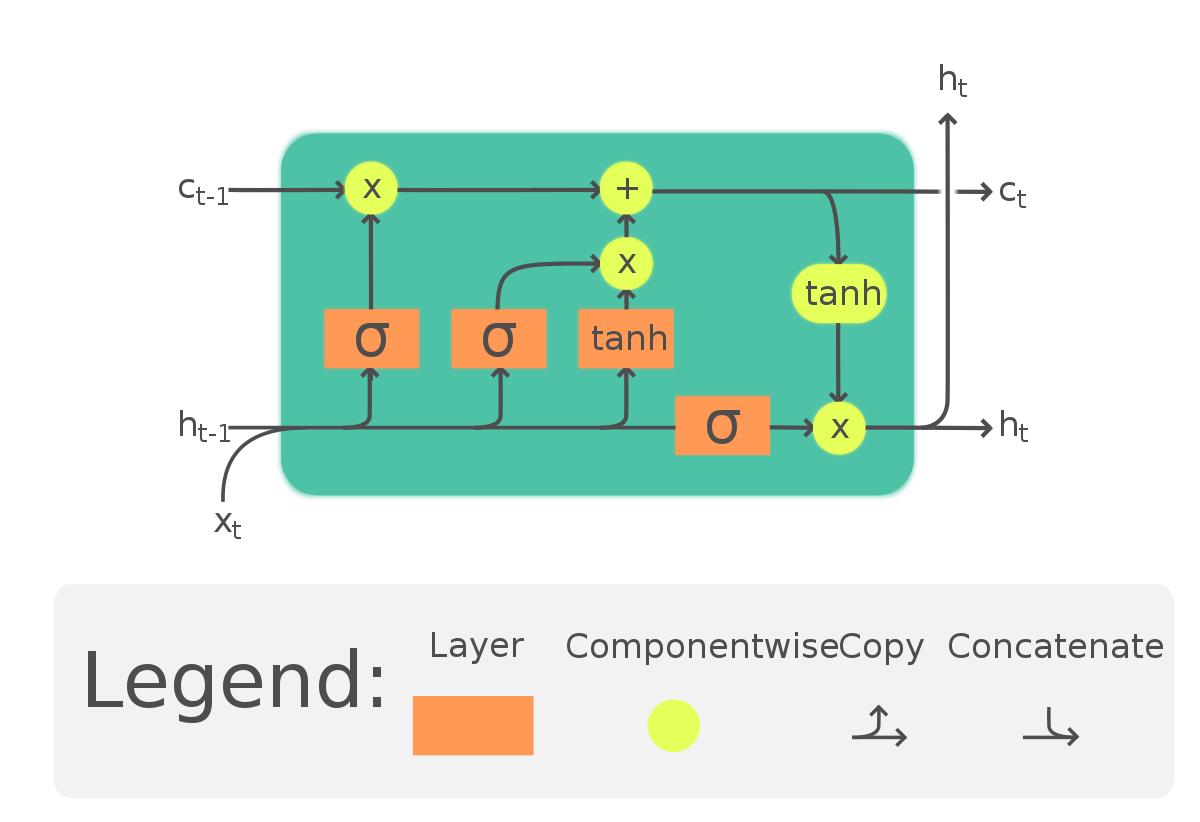

### Prueba 7: Red simple

Vamos a probar con un entrenamiento sencillo.

In [ ]:
reset_session()

In [ ]:
inputs1 = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH))
emb = tf.keras.layers.Embedding(
    input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM)(inputs1)
rnn = tf.keras.layers.LSTM(
    1,
    kernel_regularizer=tf.keras.regularizers.L2()
    )(emb)
dense = tf.keras.layers.Dense(1)(rnn)
model = tf.keras.Model(inputs=inputs1, outputs=dense)

In [ ]:
model.summary()

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

In [ ]:
history = model.fit(seq_train_ds, epochs=5,
                    validation_data=seq_validation_ds,
                    batch_size=BATCH_SIZE)

In [ ]:
plot_history(history)

Vamos a explorar cómo reacciona la red a las secuencias.

In [ ]:
emb_weights = model.layers[1].get_weights()
rnn_weights = model.layers[2].get_weights()
dense_weights = model.layers[3].get_weights()

In [ ]:
inputs1 = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH)) # No ponemos el batch_size. 32, 250 fallaría
emb = tf.keras.layers.Embedding(
    input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM)(inputs1)
rnn = tf.keras.layers.LSTM(1, return_sequences=True, return_state=True)(emb)
model = tf.keras.Model(inputs=inputs1, outputs=rnn) #rnn para tener sus outputs

In [ ]:
model.layers[1].set_weights(emb_weights)
model.layers[2].set_weights(rnn_weights)

In [ ]:
preds, state_h, state_c = model.predict(batch)

In [ ]:
n = 5
x = preds[n].flatten()
words = [seq_vectorize_layer.get_vocabulary()[word_index] for word_index in batch[n].numpy()]

print(f'state_c: {state_c[n]} \t state_h {state_h[n]}')

plt.figure(figsize=(12,6))
plt.xticks(range(MAX_SEQUENCE_LENGTH), words, rotation=75)
plt.plot(preds[n][:,0], label="unit-1")
plt.legend(loc="upper left")

In [ ]:
n = 8
x = preds[n].flatten()
words = [seq_vectorize_layer.get_vocabulary()[word_index] for word_index in batch[n].numpy()]

print(f'state_c: {state_c[n]} \t state_h {state_h[n]}')

plt.figure(figsize=(12,6))
plt.xticks(range(MAX_SEQUENCE_LENGTH), words, rotation=75)
plt.plot(preds[n][:,0], label="unit-1")
plt.legend(loc="upper left")

Por el momento los resultados son mejores que con la red análoga utilizando unidades tipo `SimpleRNN`, y el comportamiento de la red al procesar secuencias es similar.

### Prueba 8: más unidades.

Vamos a ver cómo cambian los resultados añadiendo distintas unidades.

In [ ]:
reset_session()

In [ ]:
inputs1 = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH)) # No ponemos el batch_size. 32, 250 fallaría
emb = tf.keras.layers.Embedding(
    input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM)(inputs1)
rnn = tf.keras.layers.LSTM(
    4,
    kernel_regularizer=tf.keras.regularizers.L2()
    )(emb)
dense = tf.keras.layers.Dense(1)(rnn)
model = tf.keras.Model(inputs=inputs1, outputs=dense)

In [ ]:
model.summary()

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

In [ ]:
history = model.fit(seq_train_ds, epochs=5,
                    validation_data=seq_test_ds,
                    batch_size=BATCH_SIZE)

In [ ]:
plot_history(history)

Los resultados por el momento son bastante similares a los obtenidos anteriormente.

In [ ]:
emb_weights = model.layers[1].get_weights()
rnn_weights = model.layers[2].get_weights()
dense_weights = model.layers[3].get_weights()

In [ ]:
inputs1 = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH)) # No ponemos el batch_size. 32, 250 fallaría
emb = tf.keras.layers.Embedding(
    input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM)(inputs1)
rnn = tf.keras.layers.LSTM(
    4,
    return_sequences=True,
    kernel_regularizer=tf.keras.regularizers.L2()
    )(emb)
dense = tf.keras.layers.Dense(1)(rnn)
model = tf.keras.Model(inputs=inputs1, outputs=rnn)

In [ ]:
model.layers[1].set_weights(emb_weights)
model.layers[2].set_weights(rnn_weights)
#model.layers[3].set_weights(dense_weights)

In [ ]:
preds = model.predict(batch)

In [ ]:
n = 5
x = preds[n].flatten()
words = [seq_vectorize_layer.get_vocabulary()[word_index] for word_index in batch[n].numpy()]
for i, w in enumerate(dense_weights[0]):
  print(f'unit-{i+1} weight:', w[0])

plt.figure(figsize=(12,6))
plt.xticks(range(MAX_SEQUENCE_LENGTH), words, rotation=75)
plt.plot(preds[n][:,0], label="unit-1")
plt.plot(preds[n][:,1], label="unit-2")
plt.plot(preds[n][:,2], label="unit-3")
plt.plot(preds[n][:,3], label="unit-4")
plt.legend(loc="upper left")

In [ ]:
n = 8
x = preds[n].flatten()
words = [seq_vectorize_layer.get_vocabulary()[word_index] for word_index in batch[n].numpy()]
for i, w in enumerate(dense_weights[0]):
  print(f'unit-{i+1} weight:', w[0])

plt.figure(figsize=(12,6))
plt.xticks(range(MAX_SEQUENCE_LENGTH), words, rotation=75)
plt.plot(preds[n][:,0], label="unit-1")
plt.plot(preds[n][:,1], label="unit-2")
plt.plot(preds[n][:,2], label="unit-3")
plt.plot(preds[n][:,3], label="unit-4")
plt.legend(loc="upper left")

Lo que sí llama la atención, es que con este tipo de redes las secuencias de outputs asociadas a cada unidad son mucho más estables.

Claramente, la división en dos canales de memoria, uno más estable y otro más volátil, tiene un claro impacto en cómo la red representa las distintas secuencias.

En este punto, cabe preguntarse cómo se comportarán con secuencias más largas.

### Prueba 9: Variación de longitud

Si bien con las unidades de tipo `SimpleRNN` vimos que había problemas al procesar secuencias más largas, cabe explorar si este problema se soluciona al trabajar con este tipo de unidades, dado que han sido diseñadas para mejorar cómo se procesan secuencias más largas.

Por tanto, vamos a realizar una prueba análoga para comprobar cómo se comportan este tipo de redes frente a distintas longitudes.

In [ ]:
reset_session()

In [ ]:
long_vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=500)

In [ ]:
def filter_labels(text, labels):
  return text

train_text = raw_train_ds.map(filter_labels)
long_vectorize_layer.adapt(train_text)

In [ ]:
long_vectorize_layer.adapt(train_text)

In [ ]:
def long_vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return long_vectorize_layer(text), label

In [ ]:
long_train_ds = raw_train_ds.map(long_vectorize_text)
long_test_ds = raw_test_ds.map(long_vectorize_text)

In [ ]:
long_train_ds = configure_dataset(long_train_ds)
long_test_ds = configure_dataset(long_test_ds)

Esta vez, vamos a iterar entre 20 y 200 tokens.

In [ ]:
lengths = [(i+1)*20 for i in range(10)]

In [ ]:
%%time
accs = []
val_accs = []
for NEW_LENGTH in lengths:

  reset_session()
  
  @tf.autograph.experimental.do_not_convert
  def shorten(vects, labels):
    return vects[:,:NEW_LENGTH], labels

  new_train_ds = long_train_ds.map(shorten)
  new_test_ds = long_test_ds.map(shorten)

  inputs1 = layers.Input(shape=(NEW_LENGTH))
  emb = tf.keras.layers.Embedding(
      input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM)(inputs1)
  rnn = tf.keras.layers.LSTM(
      1,
      kernel_regularizer=tf.keras.regularizers.L2()
      )(emb)
  model = tf.keras.Model(inputs=inputs1, outputs=rnn)

  model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam(1e-3),
                metrics=['accuracy'])
  t0 = time.time()
  history = model.fit(new_train_ds, epochs=5,
                      validation_data=new_test_ds,
                      batch_size=BATCH_SIZE,
                      verbose=0)
  t1 = time.time()
  accs.append(history.history['accuracy'][-1])
  val_accs.append(history.history['val_accuracy'][-1])
  print(NEW_LENGTH, accs[-1], val_accs[-1], f'{t1 - t0:4.2f} s')

In [ ]:
results = pd.DataFrame({'lenght': lengths, 'acc':accs, 'val_acc':val_accs})

In [ ]:
sns.lineplot(results, x='lenght', y='acc', label='acc')
sns.lineplot(results, x='lenght', y='val_acc', label='val_acc')

Queda claro que con este tipo de unidades podemos procesar con mejores resultados secuencias más largas que con unidades de tipo `SimpleRNN`, sin embargo, los mejores resultados se siguen obteniendo con secuencias relativamente cortas.

Esto puede ser algo concreto del problema que estamos tratando, y habría que probarlo en clasificación de textos más largos.

### Prueba 10: Variación de longitud y unidades

En el apartado anterior hicimos las pruebas con una única unidad, para que los resultados fuesen equiparables a los del primer apartado. Sin embargo, cabe preguntarse si el comportamiento cambiará con más unidades.

De hecho, cabría hacerse la misma pregunta, apilando más unidades. Sin embargo, no entraremos ahora en esa comprobación.

In [ ]:
lengths = [(i+1)*20 for i in range(10)]

In [ ]:
%%time
accs = []
val_accs = []
for NEW_LENGTH in lengths:

  reset_session()
  
  @tf.autograph.experimental.do_not_convert
  def shorten(vects, labels):
    return vects[:,:NEW_LENGTH], labels

  new_train_ds = long_train_ds.map(shorten)
  new_test_ds = long_test_ds.map(shorten)

  inputs1 = layers.Input(shape=(NEW_LENGTH))
  emb = tf.keras.layers.Embedding(
      input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM)(inputs1)
  rnn = tf.keras.layers.LSTM(
      4,
      kernel_regularizer=tf.keras.regularizers.L2()
      )(emb)
  dense = tf.keras.layers.Dense(1)(rnn)
  model = tf.keras.Model(inputs=inputs1, outputs=dense)

  model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam(1e-3),
                metrics=['accuracy'])
  t0 = time.time()
  history = model.fit(new_train_ds, epochs=5,
                      validation_data=new_test_ds,
                      batch_size=BATCH_SIZE,
                      verbose=0)
  t1 = time.time()
  accs.append(history.history['accuracy'][-1])
  val_accs.append(history.history['val_accuracy'][-1])
  print(NEW_LENGTH, accs[-1], val_accs[-1], f'{t1 - t0:4.2f} s')

In [ ]:
results = pd.DataFrame({'lenght': lengths, 'acc':accs, 'val_acc':val_accs})

In [ ]:
sns.lineplot(results, x='lenght', y='acc', label='acc')
sns.lineplot(results, x='lenght', y='val_acc', label='val_acc')

Tras esta prueba, las mejoras con longitudes mayores no son signficativas. Vamos a pasar a realizar entrenamientos.

### Entrenamiento 04: Stacked LSTM

Vamos a reproducir las condiciones del entrenamiento con mejores resultados hasta el momento, pero sustituyendo las unidades `SimpleRNN` por unidades tipo `LSTM`.

In [ ]:
reset_session()

In [ ]:
inputs1 = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH)) # No ponemos el batch_size. 32, 250 fallaría
emb = tf.keras.layers.Embedding(
    input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM)(inputs1)
rnn1 = tf.keras.layers.LSTM(
    4,
    return_sequences=True,
    kernel_regularizer=tf.keras.regularizers.L2()
    )(emb)
rnn2 = tf.keras.layers.LSTM(
    4,
    kernel_initializer=tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=73),#HeNormal(seed=73),
    recurrent_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.05, maxval=0.05, seed=73
    ),
    bias_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.05, maxval=0.05, seed=73
    ),
    kernel_regularizer=tf.keras.regularizers.L2()
    )(rnn1)
dense = tf.keras.layers.Dense(1)(rnn2)
model = tf.keras.Model(inputs=inputs1, outputs=dense)

In [ ]:
model.summary()

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    seq_train_ds,
    epochs=20,
    validation_data=seq_validation_ds,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping_cb, learning_rate_cb]
)

#### Results

In [ ]:
plot_history(history)

In [ ]:
model.evaluate(seq_test_ds)

In [ ]:
model.evaluate(seq_test_ds)

In [ ]:
preds = model.predict(seq_test_ds)

In [ ]:
get_metrics(model, seq_test_ds)

In [ ]:
plot_confusion_matrix(model, seq_test_ds)

Las métricas obtenidas son levemente peores que en la mejor prueba hasta el momento, pero la diferencia es tan pequeña que no es significativa (78% vs 77% de precisión).

Vamos a explorar internamente el modelo.

#### Explore

##### 2nd stack

In [ ]:
emb_weights = model.layers[1].get_weights()
rnn1_weights = model.layers[2].get_weights()
rnn2_weights = model.layers[3].get_weights()
dense_weights = model.layers[4].get_weights()

In [ ]:
inputs1 = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH)) # No ponemos el batch_size. 32, 250 fallaría
emb = tf.keras.layers.Embedding(
    input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM)(inputs1)
rnn1 = tf.keras.layers.LSTM(4, return_sequences=True)(emb)
rnn2 = tf.keras.layers.LSTM(4, return_sequences=True)(rnn1)
dense = tf.keras.layers.Dense(1)(rnn2)
model = tf.keras.Model(inputs=inputs1, outputs=rnn2) #rnn para tener sus outputs

In [ ]:
model.layers[1].set_weights(emb_weights)
model.layers[2].set_weights(rnn1_weights)
model.layers[3].set_weights(rnn2_weights)

In [ ]:
batch = list(seq_train_ds)[0][0]

In [ ]:
preds = model.predict(batch)

In [ ]:
n = 5
x = preds[n].flatten()
words = [seq_vectorize_layer.get_vocabulary()[word_index] for word_index in batch[n].numpy()]
for i, w in enumerate(dense_weights[0]):
  print(f'unit-{i+1} weight:', w[0])

plt.figure(figsize=(12,6))
plt.xticks(range(MAX_SEQUENCE_LENGTH), words, rotation=75)
plt.plot(preds[n][:,0], label="unit-1")
plt.plot(preds[n][:,1], label="unit-2")
plt.plot(preds[n][:,2], label="unit-3")
plt.plot(preds[n][:,3], label="unit-4")
plt.legend(loc="upper left")

Como podemos observar, el comportamiento de los outputs es el más suave de los obtenidos hasta el momento. Veamso qué ocurre con la primera capa.

##### 1st stack

In [ ]:
inputs1 = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH)) # No ponemos el batch_size. 32, 250 fallaría
emb = tf.keras.layers.Embedding(
    input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM)(inputs1)
rnn1 = tf.keras.layers.LSTM(4, return_sequences=True)(emb)
dense = tf.keras.layers.Dense(1)(rnn1)
model = tf.keras.Model(inputs=inputs1, outputs=rnn1) #rnn para tener sus outputs

In [ ]:
model.layers[1].set_weights(emb_weights)
model.layers[2].set_weights(rnn1_weights)

In [ ]:
preds = model.predict(batch)

In [ ]:
n = 5
x = preds[n].flatten()
words = [seq_vectorize_layer.get_vocabulary()[word_index] for word_index in batch[n].numpy()]
for i, w in enumerate(dense_weights[0]):
  print(f'unit-{i+1} weight:', w[0])

plt.figure(figsize=(12,6))
plt.xticks(range(MAX_SEQUENCE_LENGTH), words, rotation=75)
plt.plot(preds[n][:,0], label="unit-1")
plt.plot(preds[n][:,1], label="unit-2")
plt.plot(preds[n][:,2], label="unit-3")
plt.plot(preds[n][:,3], label="unit-4")
plt.legend(loc="upper left")

En esta capa, las progresiones son algo menos suaves que en la segunda capa, pero son mucho más estables que usando `SimpleRNN`.

Vemos claramente que se cumple la hipótesis de que a mayor número de capas, mayor estabilidad de las decisiones de la red, y también vemos que en este caso, la estabilidad es mayor que con redes más simples.

### Entrenamiento 05: Dropout

Durante los últimos entrenamientos los modelos que hemos entrenado han sufrido de cierto nivel de overfitting, que les impedía mejorar. Vamos a intentar corregirlo introduciendo mecanismos de dropout en los entrenamientos. Adicionalmente vamos a reducir de 4 a 2 unidades, para intentar reducir el overfitting.

In [ ]:
reset_session()

In [ ]:
inputs1 = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH)) # No ponemos el batch_size. 32, 250 fallaría
emb = tf.keras.layers.Embedding(
    input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM)(inputs1)
rnn1 = tf.keras.layers.LSTM(
    2,
    return_sequences=True,
    kernel_regularizer=tf.keras.regularizers.L2(),
    dropout=0.4,
    recurrent_dropout=0.2
    )(emb)
rnn2 = tf.keras.layers.LSTM(
    2,
    dropout=0.4,
    recurrent_dropout=0.2,
    kernel_regularizer=tf.keras.regularizers.L2()
    )(rnn1)
dense = tf.keras.layers.Dense(1)(rnn2)
model = tf.keras.Model(inputs=inputs1, outputs=dense)

In [ ]:
model.summary()

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    seq_train_ds,
    epochs=20,
    validation_data=seq_validation_ds,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping_cb, learning_rate_cb]
)

#### Results

In [ ]:
plot_history(history)

In [ ]:
model.evaluate(seq_test_ds)

In [ ]:
model.evaluate(seq_test_ds)

In [ ]:
preds = model.predict(seq_test_ds)

In [ ]:
get_metrics(model, seq_test_ds)

En este caso tampoco hemos encontrado una mejora clara de los resultados, obteniendo métricas ligeramente por debajo del 78% de precisión.

In [ ]:
plot_confusion_matrix(model, seq_test_ds)

## GRU

Finalmente vamos a probar con unidades tipo `GRU`. Son muy similares a las unidades `LSTM`, con lo que vamos a reproducir directamente los últimos experimentos con este tipo de unidades.

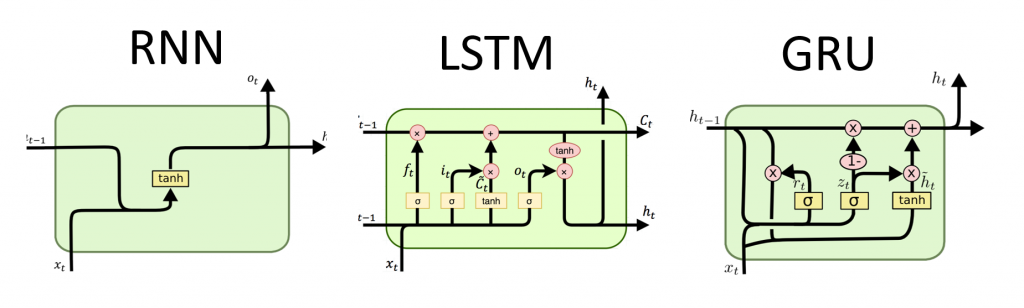

### Entrenamiento 06: Unidades GRU apiladas

Vamos a reproducir uno de los entrenamientos con los que hemos obtenido buenos resultados, esta vez aplicando unidades de tipo `GRU`.

In [ ]:
reset_session()

In [ ]:
inputs1 = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH))
emb = tf.keras.layers.Embedding(
    input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM)(inputs1)
rnn1 = tf.keras.layers.GRU(
    2,
    return_sequences=True,
    kernel_regularizer=tf.keras.regularizers.L2(),
    dropout=0.2,
    recurrent_dropout=0.2
    )(emb)
rnn2 = tf.keras.layers.GRU(
    2,
    dropout=0.2,
    recurrent_dropout=0.2,
    kernel_regularizer=tf.keras.regularizers.L2()
    )(rnn1)
dense = tf.keras.layers.Dense(1)(rnn2)
model = tf.keras.Model(inputs=inputs1, outputs=dense)

In [ ]:
model.summary()

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    seq_train_ds,
    epochs=20,
    validation_data=seq_validation_ds,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping_cb, learning_rate_cb]
)

#### Results

In [ ]:
plot_history(history)

In [ ]:
model.evaluate(seq_test_ds)

In [ ]:
model.evaluate(seq_test_ds)

In [ ]:
preds = model.predict(seq_test_ds)

In [ ]:
get_metrics(model, seq_test_ds)

Como podemos ver, no se presenta ninguna mejora respecto a las redes `LSTM`. Veremos si encontramos alguna diferencia en algún otro punto.

In [ ]:
plot_confusion_matrix(model, seq_test_ds)

#### Explore

Vamos a, como en apartados anteriore, explorar cómo se comportan internamente los elementos de esta red, y entender si presenta grandes diferencias con las redes vistas hasta el momento.

In [ ]:
get_gradient_overview(model, seq_train_ds)

##### 2nd stack

In [ ]:
emb_weights = model.layers[1].get_weights()
rnn1_weights = model.layers[2].get_weights()
rnn2_weights = model.layers[3].get_weights()
dense_weights = model.layers[4].get_weights()

In [ ]:
inputs1 = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH))
emb = tf.keras.layers.Embedding(
    input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM)(inputs1)
rnn1 = tf.keras.layers.GRU(
    2,
    return_sequences=True,
    kernel_regularizer=tf.keras.regularizers.L2(),
    dropout=0.2,
    recurrent_dropout=0.2
    )(emb)
rnn2 = tf.keras.layers.GRU(
    2,
    dropout=0.2,
    recurrent_dropout=0.2,
    kernel_regularizer=tf.keras.regularizers.L2()
    )(rnn1)
dense = tf.keras.layers.Dense(1)(rnn2)
model = tf.keras.Model(inputs=inputs1, outputs=rnn2)

In [ ]:
model.layers[1].set_weights(emb_weights)
model.layers[2].set_weights(rnn1_weights)
model.layers[3].set_weights(rnn2_weights)

In [ ]:
batch = list(seq_train_ds)[0][0]

In [ ]:
preds = model.predict(batch)

In [ ]:
n = 5
x = preds[n].flatten()
words = [seq_vectorize_layer.get_vocabulary()[word_index] for word_index in batch[n].numpy()]
for i, w in enumerate(dense_weights[0]):
  print(f'unit-{i+1} weight:', w[0])

plt.figure(figsize=(12,6))
plt.xticks(range(MAX_SEQUENCE_LENGTH), words, rotation=75)
plt.plot(preds[:,0], label="unit-1")
plt.plot(preds[:,1], label="unit-2")
plt.legend(loc="upper left")

Podemos observar un comportamiento mucho más errático que en todos los ejemplos anteriores. Revisemos la priemra capa.

##### 1st stack

In [ ]:
inputs1 = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH))
emb = tf.keras.layers.Embedding(
    input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM)(inputs1)
rnn1 = tf.keras.layers.GRU(
    2,
    return_sequences=True,
    kernel_regularizer=tf.keras.regularizers.L2(),
    dropout=0.2,
    recurrent_dropout=0.2
    )(emb)
rnn2 = tf.keras.layers.GRU(
    2,
    dropout=0.2,
    recurrent_dropout=0.2,
    kernel_regularizer=tf.keras.regularizers.L2()
    )(rnn1)
dense = tf.keras.layers.Dense(1)(rnn2)
model = tf.keras.Model(inputs=inputs1, outputs=rnn1)

In [ ]:
model.layers[1].set_weights(emb_weights)
model.layers[2].set_weights(rnn1_weights)

In [ ]:
batch = list(seq_train_ds)[0][0]

In [ ]:
preds = model.predict(batch)

In [ ]:
n = 5
x = preds[n].flatten()
words = [seq_vectorize_layer.get_vocabulary()[word_index] for word_index in batch[n].numpy()]
for i, w in enumerate(dense_weights[0]):
  print(f'unit-{i+1} weight:', w[0])

plt.figure(figsize=(12,6))
plt.xticks(range(MAX_SEQUENCE_LENGTH), words, rotation=75)
plt.plot(preds[n][:,0], label="unit-1")
plt.plot(preds[n][:,1], label="unit-2")
plt.legend(loc="upper left")

Como podemos observar, este comportamiento va en linea con lo visto anteriormente, es mucho menos herrático y con más sentido.

Esto sugiere que la red probablemente esté sobredimensionada. Vamos a llevar a cabo un entrenamiento más sencillo.

### Entrenamiento 07: GRU simple

In [ ]:
reset_session()

In [ ]:
inputs1 = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH))
emb = tf.keras.layers.Embedding(
    input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM)(inputs1)
rnn = tf.keras.layers.GRU(
    1,
    return_sequences=False,
    kernel_regularizer=tf.keras.regularizers.L2(),
    dropout=0.2,
    recurrent_dropout=0.2
    )(emb)
dense = tf.keras.layers.Dense(1)(rnn)
model = tf.keras.Model(inputs=inputs1, outputs=dense)

In [ ]:
model.summary()

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    seq_train_ds,
    epochs=20,
    validation_data=seq_validation_ds,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping_cb, learning_rate_cb]
)

#### Results

In [ ]:
plot_history(history)

In [ ]:
model.evaluate(seq_test_ds)

In [ ]:
model.evaluate(seq_test_ds)

In [ ]:
preds = model.predict(seq_test_ds)

In [ ]:
get_metrics(model, seq_test_ds)

En esta ocasión los resultados han sido levemente peores que lo quue veníamos obteniendo en las pruebas anteriores, por lo que la reducción en unidades tiene un impacto leve.

In [ ]:
plot_confusion_matrix(model, seq_test_ds)

### Entrenamiento 08: GRU simple bidireccional

Finalmente, vamos a rescatar el concepto de red bidireccional para ver si tiene un impacto positivo en este tipo de redes.

In [ ]:
reset_session()

In [ ]:
inputs1 = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH))
emb = tf.keras.layers.Embedding(
    input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM)(inputs1)
rnn = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(
    1,
    kernel_regularizer=tf.keras.regularizers.L2(),
    dropout=0.6,
    recurrent_dropout=0.3
    ))(emb)
dense = tf.keras.layers.Dense(1)(rnn)
model = tf.keras.Model(inputs=inputs1, outputs=dense)

In [ ]:
model.summary()

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    seq_train_ds,
    epochs=20,
    validation_data=seq_validation_ds,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping_cb, learning_rate_cb]
)

#### Results

In [ ]:
plot_history(history)

In [ ]:
model.evaluate(seq_test_ds)

In [ ]:
model.evaluate(seq_test_ds)

In [ ]:
preds = model.predict(seq_test_ds)

In [ ]:
get_metrics(model, seq_test_ds)

En este caso se obtiene una leve mejora, pero viene estando alineado con los resultados obtenidos hasta el momento (rondando el 80% de precisión).

Parece que hemos llegado al límite de lo que podemos obtener con estas aproximaciones.

In [ ]:
plot_confusion_matrix(model, seq_test_ds)

# Conclusiones

Las redes recurrentes son una opción que se aplica con éxito a problemas de clasificación de texto, sin embargo, su naturaleza secuencial hace que sea muy complejo alcanzar resultados óptimos.

Hemos encontrado dificultades para trabajar con secuencias de longitud media y larga. Además son especialmente sensibles a los problemas típicos de las redes neuronales. Es la primera vez que con redes relativamente sencillas encontramos problemas relacionados con los gradientes, o tan sensibles a la inicialización de parámetros.

Podemos concluir que son una solución eficaz para problemas de clasificación de textos cortos, donde las relaciones de las secuencias de palabras son importantes. Para clasificación de textos largos, es posible que otras aproximaciones ya vistas sean más efectivas